In [18]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from subprocess import run
import os

In [19]:
def makeFactorsIni(stm, color_list, gene, factor_ini_name = 'combined_factors'):
    
    factor_ini = 'pygenometracks/' + factor_ini_name + '.ini'
    
    if os.path.isfile(factor_ini):
        run('rm pygenometracks/*.ini' + factor_ini, shell=True)
        run('rm pygenometracks/*.bed', shell=True)
        run('rm pygenometracks/*.bw', shell=True)
    
    ymax = stm.max().max()
    
    factor_list = list(stm.columns)
    
    
    for i in range(len(factor_list)):
        factor = factor_list[i]
        color = color_list[i]
        make_bedGraph(stm, factor, gene)
        bedGraphToBigWig('pygenometracks/' + factor + '.' + gene)
        
        
        
        WriteBigWigIniFactor('pygenometracks/' + factor + '.' + gene, color, ymax)
        
        
        cmd = 'cat pygenometracks/'+ factor + '.' + gene + '.ini >> ' + factor_ini
        
        run(cmd, shell=True)
        
    WriteAllFactorsTrack(factor_list, color_list, gene, ymax, factor_ini)
    
    pygenome_cmd(factor_ini, factor_ini_name, stm.index)
    
    
def pygenome_cmd(factor_ini, factor_ini_name, stm_idx):
    
    chrom, start = stm_idx[0].split('.')
    chrom, end = stm_idx[-1].split('.')
    
    region = chrom + ':' + start + '-' + end
    
    out_png = 'plots/' + factor_ini_name + '.png'
    
    tracks = '<(cat {factor_ini} PremadeTracks/transcripts.hg38.ini)'.format(factor_ini = factor_ini)
    
    template = '''pyGenomeTracks --tracks {tracks} --region {region} --outFileName {out_png}'''
    
    template_cmd = template.format(tracks=tracks, region = region, out_png = out_png)
    
    print(template_cmd)


def make_bedGraph(stm, factor, gene):
    chrom = stm.index[0].split('.')[0][3:]
    start = stm.index[0].split('.')[1]
    end = stm.index[-1].split('.')[1]
    
    with open('pygenometracks/' + factor + '.' + gene + '.bed', 'w') as fh:
        fh.write('#bedGraph section ' + chrom + ':' + start + '-' + end + '\n')
        
        for idx in stm[factor].index:
            chrom = idx.split('.')[0]
            start = str(idx.split('.')[1])
            end = str(int(idx.split('.')[1])+1)
            score = str(stm.loc[idx, factor])
            
            row = '\t'.join([chrom, start, end, score]) + '\n'
            
            fh.write(row)
            

def bedGraphToBigWig(bg):
    
    template = "bedGraphToBigWig {bg}.bed hg38.chrom.sizes {bg}.bw"

    run(template.format(bg=bg), shell=True)
    

def WriteBigWigIniFactor(bg, color, ymax):
    
    title = bg.split('/')[1].split('.')[0]
    
    template_first = '''[{bg}]
file = {bg}.bw
title = {title}
height = 2
color = {color}
type = line
alpha = 1
min_value = 0
max_value = {ymax}
number_of_bins = 1000
nans_to_zeros = true
show_data_range = true
y_axis_values = original
file_type = bigwig\n\n[spacer]
height = 0.05\n\n'''
    with open(bg + '.ini', 'a') as fh:
        template_first = template_first.format(bg=bg, color=color, ymax=ymax, title=title)
        fh.write(template_first)
            
        
    
def WriteAllFactorsTrack(factor_list, color_list, gene, ymax, factor_ini):
    
    with open(factor_ini, 'a') as fh:
    
        count = 1
        for i in range(len(factor_list)):
            factor = factor_list[i]
            color = color_list[i]
            if count == 1:
                isFirst = True
            else:
                isFirst = False

            if isFirst:
                template_first = '''[spacer]
height = 0.25\n\n[all_factors]
file = pygenometracks/{factor}.{gene}.bw
height = 2
title = All factors
color = {color}
type = line
alpha = 0
min_value = 0
max_value = {ymax}
number_of_bins = 1000
nans_to_zeros = true
show_data_range = true
y_axis_values = original
file_type = bigwig\n\n'''
                fh.write(template_first.format(factor=factor, gene=gene, color=color, ymax=ymax))


            template = '''[{factor}]
file = pygenometracks/{factor}.{gene}.bw
height = 2
color = {color}
type = line
number_of_bins = 1000
nans_to_zeros = true
show_data_range = true
overlay_previous = share-y
file_type = bigwig\n\n'''
            
            fh.write(template.format(factor=factor, gene=gene, color=color))
            count += 1
    

ERROR! Session/line number was not unique in database. History logging moved to new session 297


In [20]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.stats import norm

SRSF3_stm = pd.read_csv('../../plots/stm_plots/SRSF3_stm.tab', sep='\t', index_col=0).T
SRSF3_stm_normalized = SRSF3_stm/SRSF3_stm.max(axis=0)
annotation = pd.read_csv('../../gtex_download/sample.tsv', sep='\t', index_col=0)

In [21]:
brain_cortex = annotation.loc[annotation.tissue_id == 'Brain_Cortex'].index.intersection(SRSF3_stm.columns)
whole_blood = annotation.loc[annotation.tissue_id == 'Whole_Blood'].index.intersection(SRSF3_stm.columns)

In [22]:
def compareTissues(stm, annotation, tissue1, tissue2):
    
    tissue1_idx = annotation.loc[annotation.tissue_id == tissue1].index.intersection(stm.columns)
    tissue2_idx = annotation.loc[annotation.tissue_id == tissue2].index.intersection(stm.columns)
    
    comparison_df = pd.DataFrame()
    
    for idx in tqdm(tissue1_idx, position=0, leave=True):
        check = isGreaterThan(stm[idx], stm[tissue2_idx])
        
        comparison_df[idx] = check
        
        comparison_df.index = stm.index
        
    return comparison_df

def isGreaterThan(query, stm):
    
    greater_than = []
    
    for idx in query.index:
        
        m = np.mean(stm.loc[idx])
        s = np.min([np.std(stm.loc[idx]), 1e-6])
        
        norm_model = norm(m, s)
        
        greater_than.append(norm_model.cdf(query.loc[idx]))
        
    return greater_than

# check = isGreaterThan(SRSF3_stm_normalized[whole_blood[0]], SRSF3_stm_normalized[brain_cortex])

In [23]:
comparison = compareTissues(SRSF3_stm, annotation, 'Whole_Blood', 'Brain_Cortex')

100%|██████████| 20/20 [06:02<00:00, 18.10s/it]


In [24]:
factors =  pd.read_csv('tables/SRSF3_factors.tab', sep='\t', index_col=0).T
factors.head()

,factor1,factor2,factor3
chr6.36593354,0.000005,0.00002,0.000006
chr6.36593355,0.000005,0.00002,0.000006
chr6.36593356,0.000005,0.00002,0.000006
chr6.36593357,0.000005,0.00002,0.000006
chr6.36593358,0.000005,0.00002,0.000006


In [25]:
x = pd.DataFrame(comparison.mean(axis=1))
x.columns = ['stat']

In [26]:
x.head()

,stat
chr6.36593354,0.745675
chr6.36593355,0.745678
chr6.36593356,0.745682
chr6.36593357,0.745685
chr6.36593358,0.745598


In [27]:
x = pd.DataFrame(comparison.mean(axis=1))
x.columns = ['stat']
makeFactorsIni(x, ['purple'], 'SRSF3', factor_ini_name = 'SRSF3_bloof_vs_brain')

pyGenomeTracks --tracks <(cat pygenometracks/SRSF3_bloof_vs_brain.ini PremadeTracks/transcripts.hg38.ini) --region chr6:36593354-36606600 --outFileName plots/SRSF3_bloof_vs_brain.png


In [19]:
factors =  pd.read_csv('tables/SRSF3_factors.tab', sep='\t', index_col=0).T
makeFactorsIni(factors, ['navy', 'red', 'gold'], 'SRSF3', factor_ini_name = 'SRSF3_K3_factors')

pyGenomeTracks --tracks <(cat pygenometracks/SRSF3_K3_factors.ini PremadeTracks/transcripts.hg38.ini) --region chr6:36593354-36606600 --outFileName plots/SRSF3_K3_factors.png


In [20]:
factors =  pd.read_csv('tables/SRSF7_factors.tab', sep='\t', index_col=0).T
makeFactorsIni(factors, ['navy', 'red', 'gold'], 'SRSF7', factor_ini_name = 'SRSF7_K3_factors')

pyGenomeTracks --tracks <(cat pygenometracks/SRSF7_K3_factors.ini PremadeTracks/transcripts.hg38.ini) --region chr2:38742600-38752494 --outFileName plots/SRSF7_K3_factors.png


In [28]:
factors =  pd.read_csv('../../plots/stm_plots/SRSF10_factors.tab', sep='\t', index_col=0).T
makeFactorsIni(factors, ['navy', 'red', 'gold', 'purple', 'forestgreen'], 'SRSF10', factor_ini_name = 'SRSF10_K3_factors')

pyGenomeTracks --tracks <(cat pygenometracks/SRSF10_K3_factors.ini PremadeTracks/transcripts.hg38.ini) --region chr1:23963348-23981927 --outFileName plots/SRSF10_K3_factors.png


In [30]:
factors =  pd.read_csv('tables/SRSF1_factors.tab', sep='\t', index_col=0).T
makeFactorsIni(factors, ['navy', 'red', 'gold'], 'SRSF1', factor_ini_name = 'SRSF1_K3_factors')

pyGenomeTracks --tracks <(cat pygenometracks/SRSF1_K3_factors.ini PremadeTracks/transcripts.hg38.ini) --region chr17:57999920-58008346 --outFileName plots/SRSF1_K3_factors.png


In [36]:
factors =  pd.read_csv('tables/SRSF7_factors.tab', sep='\t', index_col=0).T


In [37]:
from sklearn.decomposition import PCA

In [38]:
loadings =  pd.read_csv('../../plots/stm_plots/SRSF3_loadings.tab', sep='\t', index_col=0).T
annotation = pd.read_csv('../../gtex_download/sample.tsv', sep='\t', index_col=0)
factors =  pd.read_csv('../../plots/stm_plots/SRSF3_factors.tab', sep='\t', index_col=0).T


In [6]:
import umap

reducer = umap.UMAP()

[0.71529362 0.16937171]
[1.65462246 0.80515069]


Text(0.5, 1.0, 'SRSF3 factors PCA')

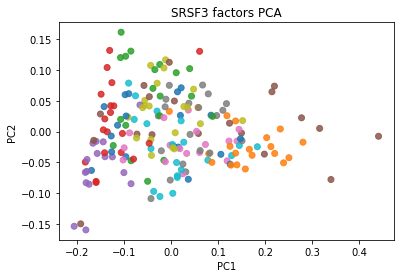

In [14]:
loadings_X = loadings[loadings.columns[(loadings.max() - loadings.min()) < 0.99]]

colors = list(plt.get_cmap('tab10').colors)
color_list = []

for x in annotation.loc[loadings_X.columns].tissue_id:
    if x == 'Heart_Atrial_Appendage':
        color_list.append(colors[0])
    if x == 'Brain_Cortex':
        color_list.append(colors[1])
    if x == 'Lung':
        color_list.append(colors[2])
    if x == 'Whole_Blood':
        color_list.append(colors[3])
    if x == 'Muscle_Skeletal':
        color_list.append(colors[4])
    if x == 'Liver':
        color_list.append(colors[5])
    if x == 'Kidney_Cortex':
        color_list.append(colors[6])
    if x == 'Spleen':
        color_list.append(colors[7])
    if x == 'Pancreas':
        color_list.append(colors[8])
    if x == 'Skin_Not_Sun_Exposed_Suprapubic':
        color_list.append(colors[9])
        

pca = PCA(n_components=2)
x = pca.fit_transform(loadings_X.T)
print(pca.explained_variance_ratio_)

print(pca.singular_values_)

    

plt.scatter(x.T[0], x.T[1], c=color_list, alpha=0.85)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('SRSF3 factors PCA')

In [17]:
embedding = reducer.fit_transform(loadings_X.T)
embedding.shape

(189, 2)

Text(0.5, 1.0, 'SRSF3 factors PCA')

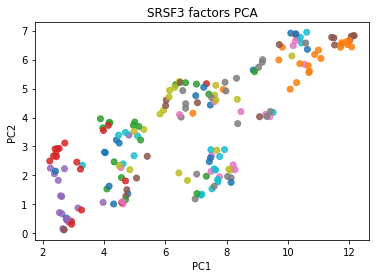

In [18]:
plt.scatter(embedding.T[0], embedding.T[1], c=color_list, alpha=0.85)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('SRSF3 factors PCA')

In [40]:
factors =  pd.read_csv('tables/SRSF3_factors.tab', sep='\t', index_col=0).T


In [41]:
stuck_samples = loadings.columns[(loadings >= (1-1e-5)).sum(axis=0)>=1]

In [30]:
factors

,factor1,factor2,factor3,factor4,factor5
chr6.36593354,0.000006,0.000005,0.000005,0.000005,0.000028
chr6.36593355,0.000006,0.000005,0.000005,0.000005,0.000028
chr6.36593356,0.000006,0.000005,0.000005,0.000005,0.000028
chr6.36593357,0.000006,0.000005,0.000005,0.000005,0.000028
chr6.36593358,0.000006,0.000005,0.000005,0.000005,0.000028
...,...,...,...,...,...
chr6.36606596,0.000006,0.000005,0.000005,0.000005,0.000010
chr6.36606597,0.000006,0.000005,0.000005,0.000005,0.000010
chr6.36606598,0.000006,0.000005,0.000005,0.000005,0.000010
chr6.36606599,0.000006,0.000005,0.000005,0.000005,0.000010


In [3]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()
import pyreadr

In [24]:
import pyreadr

SRSF3 = pyreadr.read_r('../../stm_models_1000/SRSF3.sgom_K5.rds')



In [31]:
readRDS = robjects.r['readRDS']
df = readRDS('../../stm_models_1000/SRSF3.sgom_K5.rds')
counts = df[1]

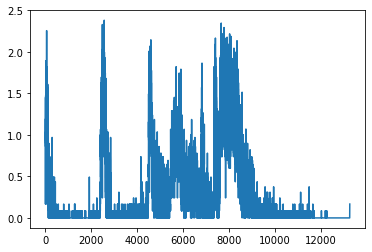

In [45]:
plt.plot(range(len(counts.loc[stuck_samples].mean(axis=0))),np.log1p(counts.loc[stuck_samples].mean(axis=0)))

In [69]:
factors =  pd.read_csv('../../plots/stm_plots/SRSF3_factors.tab', sep='\t', index_col=0).T


In [77]:
stm = pd.DataFrame(np.matrix(factors).dot(np.matrix(loadings)))
stm.columns = loadings.columns
stm.index = factors.index

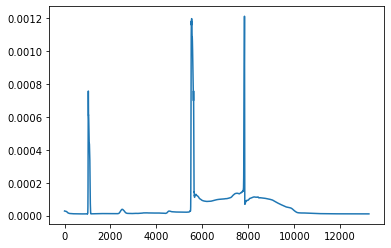

In [82]:
plt.plot(range(len(counts.loc[stuck_samples].mean(axis=0))),stm[stuck_samples].mean(axis=1))

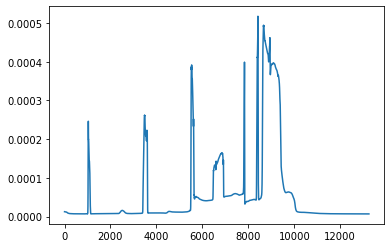

In [83]:
plt.plot(range(len(counts.loc[stuck_samples].mean(axis=0))),stm.mean(axis=1))

In [93]:
from subprocess import run
import os

def make_bedGraph(stm, IndID):
    chrom = stm.index[0].split('.')[0][3:]
    start = stm.index[0].split('.')[1]
    end = stm.index[-1].split('.')[1]
    
    #bedGraph section chr4:0-322882
    with open('pygenometracks/' + IndID + '.bed', 'w') as fh:
        fh.write('#bedGraph section ' + chrom + ':' + start + '-' + end + '\n')
        
        for idx in stm[IndID].index:
            chrom = idx.split('.')[0]
            start = str(idx.split('.')[1])
            end = str(int(idx.split('.')[1])+1)
            score = str(stm.loc[idx, IndID])
            
            row = '\t'.join([chrom, start, end, score]) + '\n'
            
            fh.write(row)
            
def make_avgbedGraph(stm, tissue):
    stm_avg = stm.mean(axis=1)
    
    chrom = stm.index[0].split('.')[0]
    start = stm.index[0].split('.')[1]
    end = stm.index[-1].split('.')[1]
    
    with open('pygenometracks/' + tissue + '_avg.bed', 'w') as fh:
        fh.write('#bedGraph section ' + chrom + ':' + start + '-' + end + '\n')
        
        for idx in stm.index:
            chrom = idx.split('.')[0]
            start = str(idx.split('.')[1])
            end = str(int(idx.split('.')[1])+1)
            score = str(stm_avg.loc[idx])
            
            row = '\t'.join([chrom, start, end, score]) + '\n'
            
            fh.write(row)
            
            
def bedGraphToBigWig(IndID, tissue):
    
    if tissue == '':
        template = "bedGraphToBigWig pygenometracks/{IndID}.bed hg38.chrom.sizes pygenometracks/{IndID}.bw"
    
        run(template.format(IndID=IndID), shell=True)
    
    else:
        
        template = "bedGraphToBigWig pygenometracks/{IndID}.bed hg38.chrom.sizes pygenometracks/{IndID}.{tissue}.bw"

        run(template.format(IndID=IndID, tissue=tissue), shell=True)
    

def WriteBigWigIni(bw_name, tissue, color, ymax, isFirst = False, isAverage=False):
    
    template = '''[{tissue}_{bw_name}]
file = pygenometracks/{bw_name}.{tissue}.bw
height = 2
color = {color}
type = line
{alpha}number_of_bins = 1000
nans_to_zeros = true
show_data_range = true
overlay_previous = share-y
file_type = bigwig\n\n'''
    
    if isAverage:
        alpha=''
    else:
        alpha='alpha = 0.1\n'
        
    template = template.format(tissue=tissue, bw_name=bw_name, color=color, alpha=alpha)
    
    with open('pygenometracks/' + tissue + '.ini', 'a') as fh:
    
        if isFirst:
            template_first = '''[{tissue}_full_blank]
file = pygenometracks/{bw_name}.{tissue}.bw
title = {tissue}
height = 2
color = {color}
type = line
alpha = 0
min_value = 0
max_value = {ymax}
number_of_bins = 1000
nans_to_zeros = true
show_data_range = true
y_axis_values = original
file_type = bigwig\n\n'''
            template_first = template_first.format(tissue=tissue, bw_name=bw_name, color=color, ymax=ymax)
            fh.write(template_first)
            
        fh.write(template)
        

def WriteBigWigIniAvg(tissue, color, ymax):
    
    template = '''[{tissue}_avg]
file = pygenometracks/{tissue}_avg.bw
height = 2
color = {color}
type = line
number_of_bins = 1000
nans_to_zeros = true
show_data_range = true
overlay_previous = share-y
file_type = bigwig\n\n'''
 
    template = template.format(tissue=tissue, color=color)
    
    with open('pygenometracks/' + tissue + '.ini', 'a') as fh:
    
        fh.write(template)
    
    
def makeTissueIni(stm, tissue, color, ymax):
    
    if os.path.isfile('pygenometracks/' + tissue + '.ini'):
        run('rm pygenometracks/' + tissue + '.ini', shell=True)
    
    counts = 1
    for IndID in stm.columns:
        if counts == 1:
            isFirst=True
        else:
            isFirst=False
        make_bedGraph(stm, IndID)
        bedGraphToBigWig(IndID, tissue)
        WriteBigWigIni(IndID, tissue=tissue, color=color, ymax=ymax, isFirst = isFirst, isAverage=False)
        
        counts += 1
        
    make_avgbedGraph(stm, tissue)
    bedGraphToBigWig(tissue + '_avg', '')
    WriteBigWigIniAvg(tissue, color, ymax)
    
    
def writeAvgTrack(tissue_list, color_list, factor_ini):
    
    with open(factor_ini, 'a') as fh:
    
        count = 1
        for i in range(len(tissue_list)):
            tissue = tissue_list[i]
            color = color_list[i]
            if count == 1:
                isFirst = True
            else:
                isFirst = False

            if isFirst:
                template_first = '''[spacer]
height = 0.25\n\n[avg_full_blank]
file = pygenometracks/{tissue}_avg.bw
height = 2
color = {color}
type = line
alpha = 0
min_value = 0
max_value = 1
number_of_bins = 1000
nans_to_zeros = true
show_data_range = true
y_axis_values = original
file_type = bigwig\n\n'''
                fh.write(template_first.format(tissue=tissue, color=color))


            template = '''[{tissue}_avg]
file = pygenometracks/{tissue}_avg.bw
height = 2
color = {color}
type = line
number_of_bins = 1000
nans_to_zeros = true
show_data_range = true
overlay_previous = share-y
file_type = bigwig\n\n'''
            
            fh.write(template.format(tissue=tissue, color=color))
            count += 1
            
            
    
def makeGeneralIni(stm_list, tissue_list, color_list, factor_ini_name = 'combined_factors'):
    
    m = np.max([x.max().max() for x in stm_list])
    
    factor_ini = 'pygenometracks/' + factor_ini_name + '.ini'
    
    if os.path.isfile(factor_ini):
        run('rm pygenometracks/*.ini', shell=True)
        run('rm pygenometracks/*.bed', shell=True)
        run('rm pygenometracks/*.bw', shell=True)
        #run('rm *.png', shell=True)
    
    for i in range(len(tissue_list)):
        stm = stm_list[i]
        tissue = tissue_list[i]
        color = color_list[i]
        
        
        makeTissueIni(stm/m, tissue, color, 1)
        
        cmd = 'cat pygenometracks/{tissue}.ini >> '.format(tissue=tissue) + factor_ini
        
        run(cmd, shell=True)
        
    writeAvgTrack(tissue_list, color_list, factor_ini)


In [89]:
stm[[x for x in loadings.columns if x not in stuck_samples]]

,GTEX-1192W-0226-SM-5EGGT,GTEX-1192X-3126-SM-5N9BY,GTEX-11EI6-0826-SM-5985V,GTEX-11EMC-0006-SM-5O9DN,GTEX-11O72-0326-SM-5986D,GTEX-11OF3-0726-SM-5BC4Z,GTEX-11ONC-1026-SM-5GU64,GTEX-11P82-0006-SM-5N9FY,GTEX-11XUK-2226-SM-5CVLL,GTEX-12584-1426-SM-5EGJ9,...,GTEX-ZEX8-2526-SM-DO92M,GTEX-ZLWG-0326-SM-4WWC7,GTEX-ZTX8-0006-SM-4YCE4,GTEX-ZUA1-2626-SM-5NQ92,GTEX-ZVP2-0526-SM-51MSC,GTEX-ZVZP-2526-SM-57WBR,GTEX-ZYFG-1626-SM-5GZYY,GTEX-ZZPT-3026-SM-5GZXH,GTEX-ZZPU-0126-SM-5E446,GTEX-ZZPU-0826-SM-5GZX5
chr6.36593354,0.000013,0.000011,0.000014,0.000011,0.000011,0.000012,0.000012,0.000013,0.000011,0.000013,...,0.000012,0.000012,0.000014,0.000013,0.000012,0.000012,0.000013,0.000010,0.000011,0.000011
chr6.36593355,0.000013,0.000011,0.000014,0.000011,0.000011,0.000012,0.000012,0.000013,0.000011,0.000013,...,0.000012,0.000012,0.000014,0.000013,0.000012,0.000012,0.000013,0.000010,0.000011,0.000011
chr6.36593356,0.000013,0.000011,0.000014,0.000011,0.000011,0.000012,0.000012,0.000013,0.000011,0.000013,...,0.000012,0.000012,0.000014,0.000013,0.000012,0.000012,0.000013,0.000010,0.000011,0.000011
chr6.36593357,0.000013,0.000011,0.000014,0.000011,0.000011,0.000012,0.000012,0.000013,0.000011,0.000013,...,0.000012,0.000012,0.000014,0.000013,0.000012,0.000012,0.000013,0.000010,0.000011,0.000011
chr6.36593358,0.000013,0.000011,0.000014,0.000011,0.000011,0.000012,0.000012,0.000013,0.000011,0.000013,...,0.000012,0.000012,0.000014,0.000013,0.000012,0.000012,0.000013,0.000010,0.000011,0.000011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chr6.36606596,0.000007,0.000006,0.000007,0.000006,0.000006,0.000007,0.000007,0.000007,0.000006,0.000007,...,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000006,0.000006,0.000006
chr6.36606597,0.000007,0.000006,0.000007,0.000006,0.000006,0.000007,0.000007,0.000007,0.000006,0.000007,...,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000006,0.000006,0.000006
chr6.36606598,0.000007,0.000006,0.000007,0.000006,0.000006,0.000007,0.000007,0.000007,0.000006,0.000007,...,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000006,0.000006,0.000006
chr6.36606599,0.000007,0.000006,0.000007,0.000006,0.000006,0.000007,0.000007,0.000007,0.000006,0.000007,...,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000007,0.000006,0.000006,0.000006


In [87]:
stm[stuck_samples]

,GTEX-11OF3-1326-SM-5N9FJ,GTEX-11WQK-0726-SM-5GU71,GTEX-13OVH-0626-SM-5L3EI,GTEX-14C5O-0005-SM-5P9ER,GTEX-14PJ4-0626-SM-6AJBS,GTEX-1AX8Z-2326-SM-731CR,GTEX-1B932-1426-SM-793AN,GTEX-1GMR3-2426-SM-7MXV2,GTEX-QEL4-0626-SM-3GIJM,GTEX-YF7O-0526-SM-5P9IO,GTEX-ZV7C-2426-SM-5NQ7Q
chr6.36593354,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028
chr6.36593355,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028
chr6.36593356,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028
chr6.36593357,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028
chr6.36593358,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028,0.000028
...,...,...,...,...,...,...,...,...,...,...,...
chr6.36606596,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010
chr6.36606597,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010
chr6.36606598,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010
chr6.36606599,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010


In [94]:
makeGeneralIni([stm[stuck_samples], stm[[x for x in loadings.columns if x not in stuck_samples]]], 
               ['factor5_samples', 'all_other'], ['purple', 'darkred'])

In [97]:
makeGeneralIni([counts.T[stuck_samples], counts.T[[x for x in loadings.columns if x not in stuck_samples]]], 
               ['factor5_samples', 'all_other'], ['purple', 'darkred'])

In [107]:
stuck_samples

Index(['GTEX-11OF3-1326-SM-5N9FJ', 'GTEX-11WQK-0726-SM-5GU71',
       'GTEX-13OVH-0626-SM-5L3EI', 'GTEX-14C5O-0005-SM-5P9ER',
       'GTEX-14PJ4-0626-SM-6AJBS', 'GTEX-1AX8Z-2326-SM-731CR',
       'GTEX-1B932-1426-SM-793AN', 'GTEX-1GMR3-2426-SM-7MXV2',
       'GTEX-QEL4-0626-SM-3GIJM', 'GTEX-YF7O-0526-SM-5P9IO',
       'GTEX-ZV7C-2426-SM-5NQ7Q'],
      dtype='object')

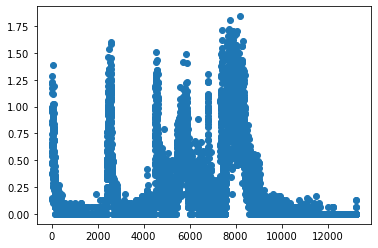

In [103]:
plt.scatter(range(len(counts.columns)), np.log1p(counts.loc[stuck_samples]).mean(axis=0))

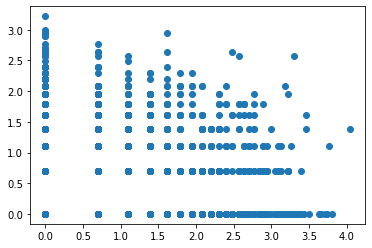

In [108]:
plt.scatter(np.log1p(counts.loc['GTEX-11OF3-1326-SM-5N9FJ']), np.log1p(counts.loc['GTEX-11WQK-0726-SM-5GU71']))

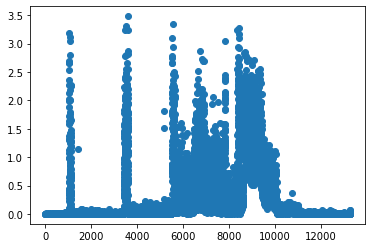

In [106]:
plt.scatter(range(len(counts.columns)), 
            np.log1p(counts.loc[[x for x in loadings.columns if x not in stuck_samples]]).mean(axis=0))

In [109]:
[x for x in loadings.columns if x not in stuck_samples]

['GTEX-1192W-0226-SM-5EGGT',
 'GTEX-1192X-3126-SM-5N9BY',
 'GTEX-11EI6-0826-SM-5985V',
 'GTEX-11EMC-0006-SM-5O9DN',
 'GTEX-11O72-0326-SM-5986D',
 'GTEX-11OF3-0726-SM-5BC4Z',
 'GTEX-11ONC-1026-SM-5GU64',
 'GTEX-11P82-0006-SM-5N9FY',
 'GTEX-11XUK-2226-SM-5CVLL',
 'GTEX-12584-1426-SM-5EGJ9',
 'GTEX-12696-1226-SM-5FQSM',
 'GTEX-12KS4-1326-SM-5LUB3',
 'GTEX-12WSF-0926-SM-6PALU',
 'GTEX-12WSH-3026-SM-5CVNI',
 'GTEX-13112-0526-SM-5EQ4S',
 'GTEX-13113-1326-SM-5GCOI',
 'GTEX-131XF-0426-SM-5HL7U',
 'GTEX-131YS-1626-SM-5HL6C',
 'GTEX-131YS-3126-SM-5KLYT',
 'GTEX-1399R-0226-SM-5IJGG',
 'GTEX-139YR-0226-SM-5IFEM',
 'GTEX-13D11-2526-SM-5KM28',
 'GTEX-13FLV-0326-SM-5N9DJ',
 'GTEX-13FLV-0626-SM-5IFEY',
 'GTEX-13JUV-0226-SM-5IJCC',
 'GTEX-13JUV-2926-SM-5LZX7',
 'GTEX-13NYB-0626-SM-5MR47',
 'GTEX-13NZ8-1226-SM-5KM4A',
 'GTEX-13NZ9-0626-SM-5IJCO',
 'GTEX-13O1R-2526-SM-5N9FW',
 'GTEX-13O3P-0626-SM-5L3D5',
 'GTEX-13O3Q-0326-SM-5L3FE',
 'GTEX-13OVH-3026-SM-5MR4N',
 'GTEX-13OW6-0826-SM-5L3GA',
 'GTEX-13OW6-1